In [425]:
import numpy as np
from optparse import OptionParser
import os
import cPickle
import os.path
import matplotlib.pyplot as plt
import scipy.interpolate as intp
from scipy.interpolate import interp1d
from matplotlib import cm
import re
from scipy import signal
from scipy.signal import hilbert
import sys

sys.path.insert(0, '../simulation')

import fluence as flu
import radiation_energy as rad
import sim_functions as sim
import helper as helper
import sim_functions as sim
import debug_sim as debug_sim


In [426]:
event_path='/Users/kmulrey/radio/events/'

In [427]:
def integrate(r,flu0,flu1):
    n=len(r)
    dr=r[1]-r[0]
    integral=0
    for i in np.arange(n-1):
        r0=r[i]
        r1=r[i+1]
        val0=r0*(flu0[i]+flu1[i])
        val1=r1*(flu0[i+1]+flu1[i+1])
        integral=integral+(val0+val1)*0.5*dr
    
    
    
    return 2*np.pi*integral*6.2415e18 # to eV


In [428]:
def integrate_one_pol(r,flu):
    n=len(r)
    dr=r[1]-r[0]
    integral=0
    for i in np.arange(n-1):
        r0=r[i]
        r1=r[i+1]
        val0=r0*(flu[i])
        val1=r1*(flu[i+1])
        integral=integral+(val0+val1)*0.5*dr
    
    
    
    return 2*np.pi*integral*6.2415e18 # to eV


In [429]:
a=10
type='proton'

In [430]:

filename=type+'_event_list.txt'
sim_dir=[]
runnr=[]
count=0

In [431]:
with open(filename) as f:
    for line in f:
        sim_dir.append(line.split()[0])
        
        runnr.append(line.split()[1])
        count=count+1



In [432]:
i=3
event= sim_dir[i].split('events/')[1].split('/')[0]
print '{0}  {1}'.format(sim_dir[i], runnr[i])

/Users/kmulrey/radio/events/225079654/1/coreas/proton/  000366


In [445]:
reload(debug_sim)
ant_pos,times,efield,zenith,az,energy,xmax=debug_sim.get_efield(sim_dir[i], runnr[i])

In [437]:
alpha=sim.GetAlpha(zenith,az,1.1837)

In [446]:
atm=sim.get_atm(event)
hi=helper.get_vertical_height(xmax,atm)   # height in cm
at=helper.get_atmosphere(hi,atm)
#rho=debug_sim.return_density_array(hi, atm)
rho=debug_sim.return_density(hi, atm)

dmax=helper.get_distance_xmax_geometric(zenith, xmax, atm)


In [447]:
print efield.shape

(160, 4082, 3)


In [473]:
ant_pos_shower=sim.ground_to_shower(ant_pos,zenith,az,B=1.1837)

In [474]:
reload(debug_sim)
e_filt,time_filt=debug_sim.lofar_filter(efield,times)
print e_filt.shape
print time_filt.shape


(160, 80, 2)
(160, 80)


In [450]:
reload(debug_sim)
flu_lofar_1,flu_lofar_2,flu_lofar_3=debug_sim.lofar_fluence(e_filt,time_filt)


In [402]:
reload(debug_sim)
print filtered_efield.shape
print times.shape
flu11,flu21,flu41=debug_sim.get_fluence(efield,times)
print flu11.shape

(160, 4082, 3)
(160, 4082)
(160, 2)


In [403]:
reload(debug_sim)
fluence=debug_sim.calculate_energy_fluence_vector(filtered_efield, times, signal_window=100., remove_noise=True)

In [470]:
reload(debug_sim)
fluence=debug_sim.calculate_energy_fluence_vector(e_filt,time_filt*1e-9, signal_window=100., remove_noise=True)

In [471]:
pos_uvw_vxb=ant_pos_shower[0::8]
pos_uvw_vxvxb=ant_pos_shower[2::8]
neg_uvw_vxvxb=ant_pos_shower[6::8]
#fluence_vxb=fluence21[0::8]
#fluence_vxvxb=fluence21[2::8]

#pos_vxvxb_all=np.concatenate([neg_uvw_vxvxb.T[1],pos_uvw_vxvxb.T[1]])
flu_vxvxb_0=np.concatenate([flu21[2::8].T[0],flu21[6::8].T[0]])
flu_vxvxb_1=np.concatenate([flu21[2::8].T[1],flu21[6::8].T[1]])

fluence_vxvxb_0=np.concatenate([fluence[2::8].T[0],fluence[6::8].T[0]])
fluence_vxvxb_1=np.concatenate([fluence[2::8].T[1],fluence[6::8].T[1]])

flu_lofar_vxvxb_0=np.concatenate([flu_lofar_2[2::8].T[0],flu_lofar_2[6::8].T[0]])
flu_lofar_vxvxb_1=np.concatenate([flu_lofar_2[2::8].T[1],flu_lofar_2[6::8].T[1]])

pos_vxvxb_all=np.concatenate([neg_uvw_vxvxb.T[1],pos_uvw_vxvxb.T[1]])

inds = pos_vxvxb_all.argsort()
            
sorted_pos=pos_vxvxb_all[inds]
sorted_flu_vxb=flu_vxvxb_0[inds]
sorted_flu_vxvxb=flu_vxvxb_1[inds]
sorted_fluence_vxb=fluence_vxvxb_0[inds]
sorted_fluence_vxvxb=fluence_vxvxb_1[inds]

sorted_flu_lofar_vxb=flu_lofar_vxvxb_0[inds]
sorted_flu_lofar_vxvxb=flu_lofar_vxvxb_1[inds]

f0 = interp1d(sorted_pos, sorted_fluence_vxb, kind='cubic')
f1 = interp1d(sorted_pos, sorted_fluence_vxvxb, kind='cubic')
        
xnew = np.linspace(0, 400, num=1000, endpoint=True)

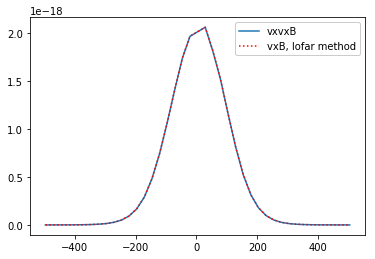

In [472]:
fig = plt.figure()
#ax1 = fig.add_subplot(1,1,1,aspect=1)
ax1 = fig.add_subplot(1,1,1)
#ax1.plot(sorted_pos,sorted_fluence_vxb,label='vxB')
ax1.plot(sorted_pos,sorted_fluence_vxb,label='vxvxB')

#ax1.plot(sorted_pos,sorted_flu_vxb,':',label='vxB, lofar old')
ax1.plot(sorted_pos,sorted_flu_lofar_vxb,color='red',linestyle=':',label='vxB, lofar method')
ax1.legend(numpoints=1,loc='upper right',framealpha=1,facecolor='white')


#ax1.plot(xnew,f0(xnew))
#ax1.plot(sorted_pos,sorted_flu_vxvxb,':')
#ax1.plot(sorted_pos,sorted_fluence_vxvxb)
#ax1.plot(xnew,f1(xnew))

#ax1.plot(ant_pos_shower.T[0],ant_pos_shower.T[1],'.')
#ax1.plot(pos_uvw_vxvxb.T[0],pos_uvw_vxvxb.T[1],'.')
#ax1.plot(neg_uvw_vxvxb.T[0],neg_uvw_vxvxb.T[1],'.')

plt.show()

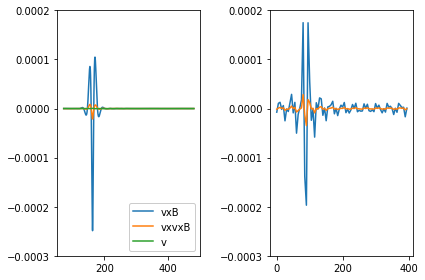

In [453]:
a=10
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)#,aspect=1)
ax2 = fig.add_subplot(1,2,2)#,aspect=1)

ax1.plot(times[a]*1e9,filtered_efield[a].T[0],label='vxB')
ax1.plot(times[a]*1e9,filtered_efield[a].T[1],label='vxvxB')
ax1.plot(times[a]*1e9,filtered_efield[a].T[2],label='v')
ax1.legend(numpoints=1,loc='lower right',framealpha=1,facecolor='white')
#ax1.axis([50,200,-0.0005,0.0002])

ax2.plot(time_filt[a],e_filt[a].T[0],label='vxB')
ax2.plot(time_filt[a],e_filt[a].T[1],label='vxvxB')
ax1.legend(numpoints=1,loc='lower right',framealpha=1,facecolor='white')
ax1.set_ylim([-0.0003, 0.0002])
ax2.set_ylim([-0.0003, 0.0002])


plt.tight_layout()

plt.show()

In [454]:
Erad=integrate(xnew,f0(xnew),f1(xnew))
Erad_vxB=integrate_one_pol(xnew,f0(xnew))
Erad_vxvxB=integrate_one_pol(xnew,f1(xnew))
a=rad.get_a(rho)

b=0.9
mag=2.03

print np.sin(alpha)*np.sqrt(Erad_vxvxB/Erad_vxB)*mag**b
print a                                               
print rho*1e3
print np.sin(alpha)

0.2518142757044228
0.3664385922022486
0.9445957424172722
0.7797944054297464
